### Davide Maniscalco

#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

## Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

### Load dataset:
In this HW, we use the IMD dataset that can be easily downloaded using Keras. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


Let's also get the word indexs (word to word-id)

*   List item
*   List item



In [3]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [0]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [5]:
decode_review(X_train[500])

"<sos> and that's why hard to rate br br from the adult point of view hmm student point of view i must say i fell nearly asleep here sure there is some laughing scene all the credit takes here eddie but that can't save the disney type of script and whole movie that's why br br 2 out of 10"

In [6]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [0]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

Since the model performs a binary classification task, we use cross-entropy as loss.

In [0]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


### Train the model:
Now we have to train the model

In [0]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 94s 478ms/step - loss: 0.6659 - accuracy: 0.5901 - val_loss: 0.6082 - val_accuracy: 0.6720
Epoch 2/10
196/196 [==============================] - 94s 478ms/step - loss: 0.4332 - accuracy: 0.8126 - val_loss: 0.3890 - val_accuracy: 0.8327
Epoch 3/10
196/196 [==============================] - 93s 473ms/step - loss: 0.2896 - accuracy: 0.8826 - val_loss: 0.3961 - val_accuracy: 0.8214
Epoch 4/10
196/196 [==============================] - 93s 476ms/step - loss: 0.2236 - accuracy: 0.9148 - val_loss: 0.3849 - val_accuracy: 0.8529
Epoch 5/10
196/196 [==============================] - 94s 481ms/step - loss: 0.1716 - accuracy: 0.9392 - val_loss: 0.3976 - val_accuracy: 0.8405
Epoch 6/10
196/196 [==============================] - 93s 472ms/step - loss: 0.1789 - accuracy: 0.9324 - val_loss: 0.4493 - val_accuracy: 0.8251
Epoch 7/10
196/196 [==============================] - 93s 474ms/step - loss: 0.1006 - accuracy: 0.9674 - val_loss: 0.5080 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

In [0]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'],label='loss')
  plt.plot(history.epoch,history.history['val_loss'],label='val_loss')
  plt.legend()
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'],label='accuracy')
  plt.plot(history.epoch,history.history['val_accuracy'],label='val_accuracy')
  plt.legend()
  plt.title('accuracy')

391/391 - 15s - loss: 0.6344 - accuracy: 0.8258
accuracy: 82.58%


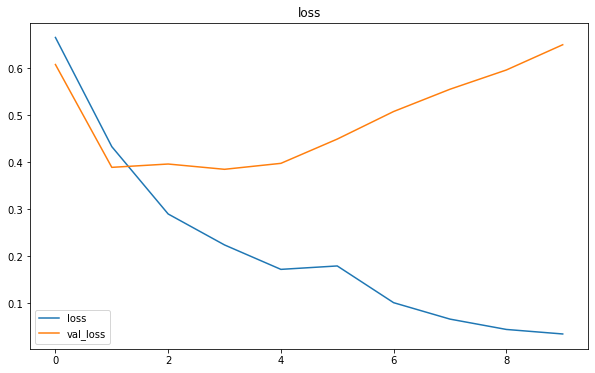

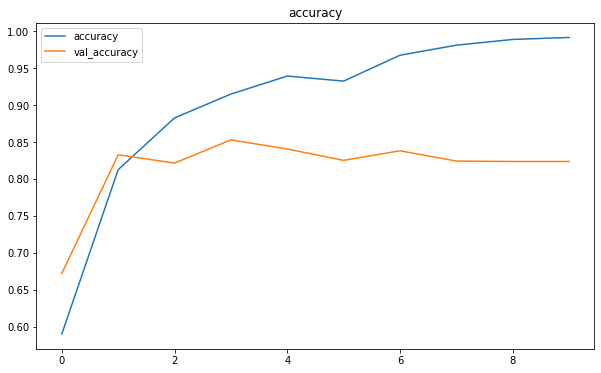

In [0]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.1: LSTM and GRU
**To complete**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**To complete**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion below*

### Differences discussion

#### LSTM

The sizes of the layers were chosen using the two theorethical formulas written above in order to have more parameters for a higher model complexity. In both cases (LSTM and GRU) the achieved performance has increased with respect to the simple RNN. It is very interesting to notice also that the training time per epoch has in both cases (LSTM and GRU) decreased of 1/5 with respect to the simpleRNN (3s with respect to 15s).

In [0]:
#N:vector length,  M: time steps
nn = 40
mm = 10
print('#parameters of LSTM: ',4*(nn*mm+nn**2+nn))

#parameters of LSTM:  8160


In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(40))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
lstm_29 (LSTM)               (None, 40)                8160      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 41        
Total params: 108,201
Trainable params: 108,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
history1 = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 6s 31ms/step - loss: 0.4882 - accuracy: 0.7471 - val_loss: 0.3670 - val_accuracy: 0.8441
Epoch 2/10
196/196 [==============================] - 6s 29ms/step - loss: 0.2471 - accuracy: 0.9053 - val_loss: 0.2932 - val_accuracy: 0.8823
Epoch 3/10
196/196 [==============================] - 5s 27ms/step - loss: 0.1932 - accuracy: 0.9306 - val_loss: 0.3063 - val_accuracy: 0.8761
Epoch 4/10
196/196 [==============================] - 5s 28ms/step - loss: 0.1565 - accuracy: 0.9443 - val_loss: 0.3667 - val_accuracy: 0.8719
Epoch 5/10
196/196 [==============================] - 5s 28ms/step - loss: 0.1323 - accuracy: 0.9550 - val_loss: 0.3553 - val_accuracy: 0.8617
Epoch 6/10
196/196 [==============================] - 5s 27ms/step - loss: 0.1160 - accuracy: 0.9620 - val_loss: 0.3891 - val_accuracy: 0.8634
Epoch 7/10
196/196 [==============================] - 5s 28ms/step - loss: 0.0937 - accuracy: 0.9697 - val_loss: 0.4254 - val_accuracy: 0.8572

391/391 - 3s - loss: 0.6351 - accuracy: 0.8475
accuracy: 84.75%


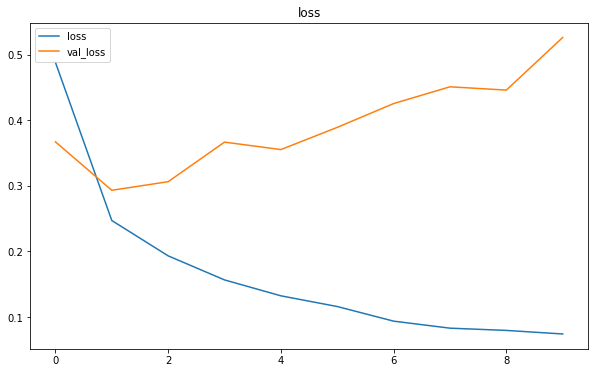

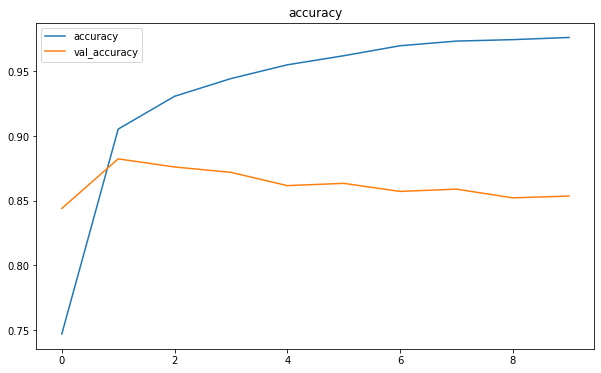

In [0]:
plot_loss(history1)
plot_accuracy(history1)
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#### GRU

In [0]:
#N:vector length,  M: time steps
nn = 47
mm = 10
print('#parameters of GRU: ',3*(nn**2+nn*mm+2*nn))

#parameters of GRU:  8319


In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(47))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

history2 = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
gru_3 (GRU)                  (None, 47)                8319      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 48        
Total params: 108,367
Trainable params: 108,367
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 6s 29ms/step - loss: 0.6584 - accuracy: 0.6172 - val_loss: 0.5883 - val_accuracy: 0.7289
Epoch 2/10
196/196 [==============================] - 6s 32ms/step - loss: 0.4245 - accuracy: 0.8181 - val_loss: 0.3422 - val_accuracy: 0.8534
Epoch 3/10
196/196 [==============================] - 6s 28ms/step - loss: 0.2542 - accurac

391/391 - 3s - loss: 0.6351 - accuracy: 0.8475
accuracy: 84.75%


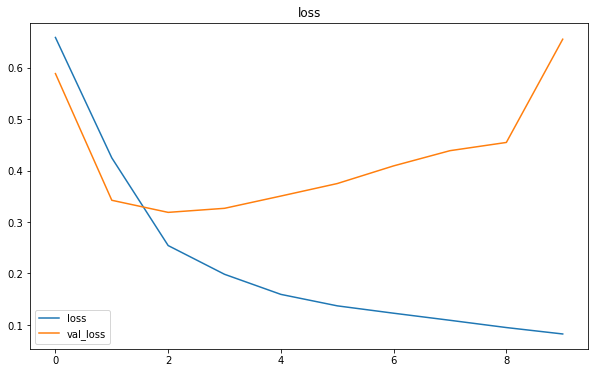

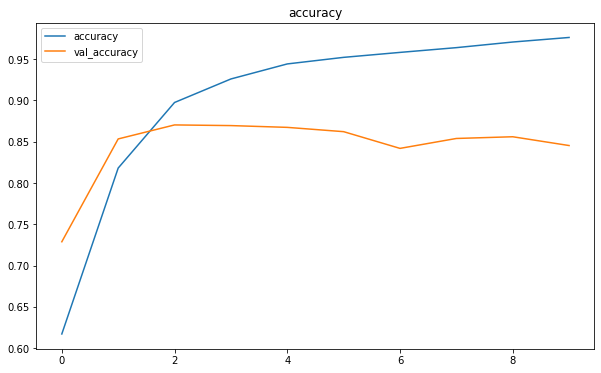

In [0]:
plot_loss(history2)
plot_accuracy(history2)
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

### Fair Comparison

#### LSTM

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(14))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

history4 = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
lstm (LSTM)                  (None, 14)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
196/196 [==============================] - 17s 88ms/step - loss: 0.5723 - accuracy: 0.6966 - val_loss: 0.4104 - val_accuracy: 0.8342
Epoch 2/10
196/196 [==============================] - 17s 86ms/step - loss: 0.3013 - accuracy: 0.8829 - val_loss: 0.3661 - val_accuracy: 0.8398
Epoch 3/10
196/196 [==============================] - 17s 86ms/step - loss: 0.2200 - accur

391/391 - 10s - loss: 0.4694 - accuracy: 0.8604
accuracy: 86.04%


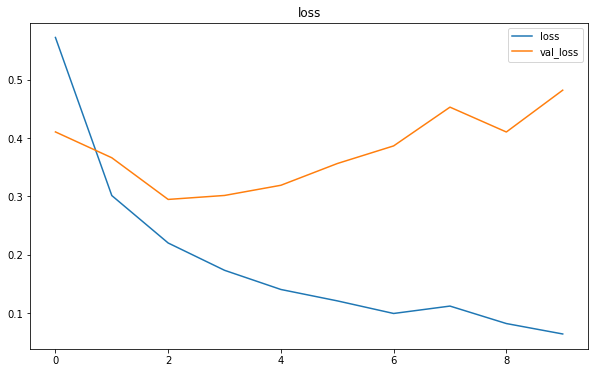

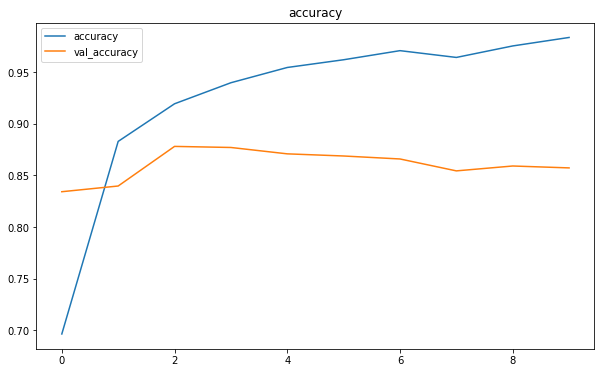

In [0]:
plot_loss(history4)
plot_accuracy(history4)
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#### GRU

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(17))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

history3 = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
gru_7 (GRU)                  (None, 17)                1479      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 18        
Total params: 101,497
Trainable params: 101,497
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 12500 samples
Epoch 1/10
25000/25000 [==============================] - 128s 5ms/sample - loss: 0.5984 - accuracy: 0.6730 - val_loss: 0.4245 - val_accuracy: 0.8149
Epoch 2/10
25000/25000 [==============================] - 124s 5ms/sample - loss: 0.3372 - accuracy: 0.8589 - val_loss: 0.3486 - val_accuracy: 0.8558
Epoch 3/10
25000/25000 [===

12500/12500 - 36s - loss: 0.4298 - accuracy: 0.8494
accuracy: 84.94%


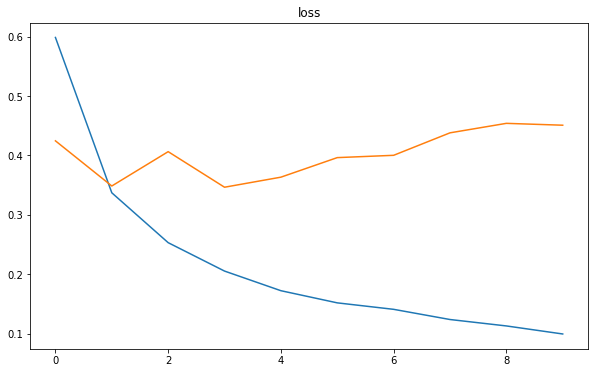

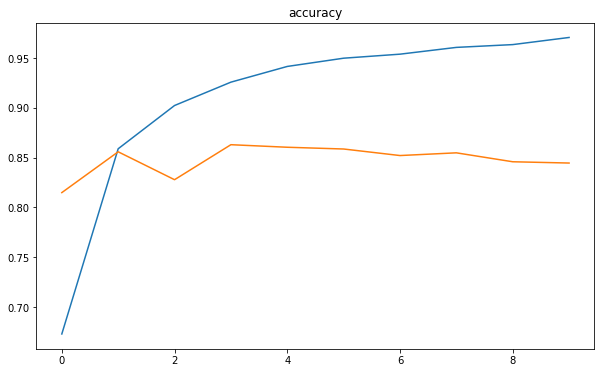

In [0]:
plot_loss(history3)
plot_accuracy(history3)
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In order to make a fair comparison, we have approximately to halve the number of neurons of the recurrent layer, both in the LSTM and in the GRU case. This decreases the training time, and it is interesting to notice that it doen't affect much the final accuracy.



```
# This is formatted as code
```

## Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [0]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 237s 12ms/sample - loss: 0.5957 - accuracy: 0.6895 - val_loss: 0.5826 - val_accuracy: 0.6954
Epoch 2/10
20000/20000 [==============================] - 237s 12ms/sample - loss: 0.4142 - accuracy: 0.8277 - val_loss: 0.3663 - val_accuracy: 0.8410
Epoch 3/10
20000/20000 [===

12500/12500 - 50s - loss: 0.4373 - accuracy: 0.8527
accuracy: 85.27%


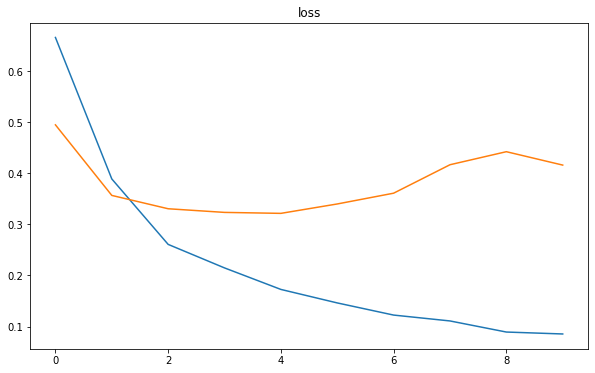

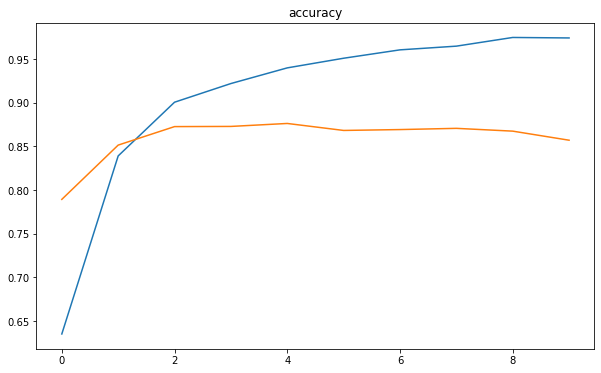

In [0]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

### Exercise 4.2: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**To complete**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue. Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion below*

Here, in order to reduce overfitting, a high dropout is needed. Here 0.5 was selected, but also even higher values seem to work. 
Addictionaly, the number of epochs was modified in order to reduce even more overfitting: it was found, in this case, an optimal number of 4 epochs. The results for other values are shown in order to demonstrate experimentally the point. 

The dropout helps in avoiding overfitting and in improving the performance. Addictionaly, reducing the number of epochs, in this situation, helps. As it is shown in below, it was found that 6 is the ideal number.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
157/157 [==============================] - 7s 47ms/step - loss: 0.6335 - accuracy: 0.6262 - val_loss: 0.

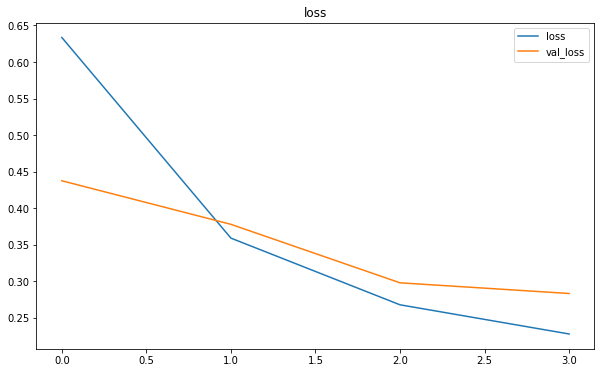

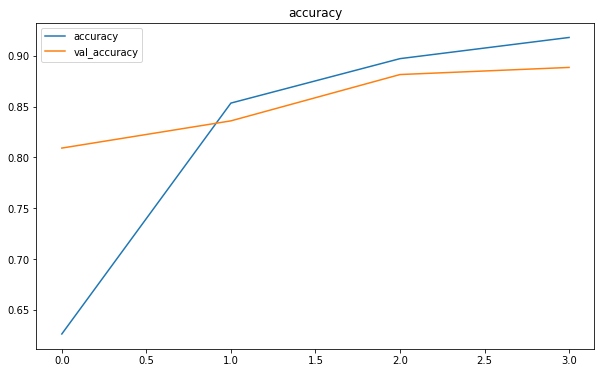

In [15]:
#   4 EPOCHS
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history20 = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=4, batch_size=128, validation_split=0.2)

plot_loss(history20)

plot_accuracy(history20)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                11008     
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
157/157 [==============================] - 28s 177ms/step - loss: 0.6686 - accuracy: 0.5816 - val_loss:

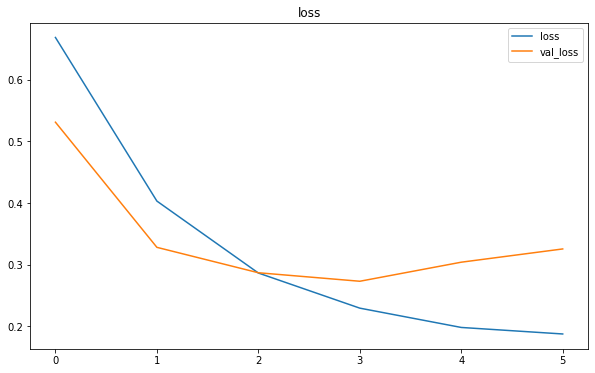

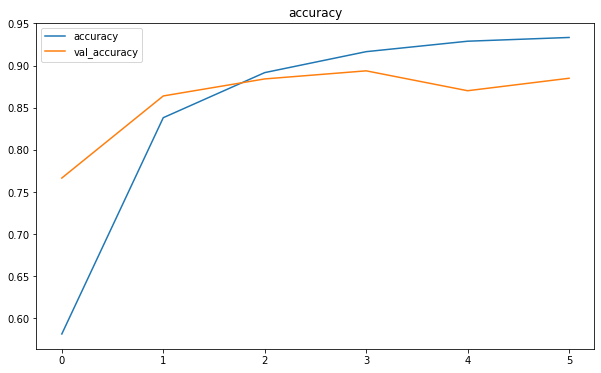

In [0]:
# 6 EPOCHS
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history6 = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=6, batch_size=128, validation_split=0.2)

plot_loss(history6)

plot_accuracy(history6)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 10)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                11008     
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 28s 176ms/step - loss: 0.6489 - accuracy: 0.6180 - val_loss

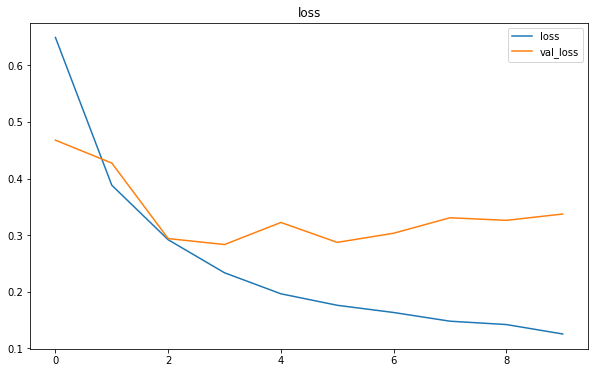

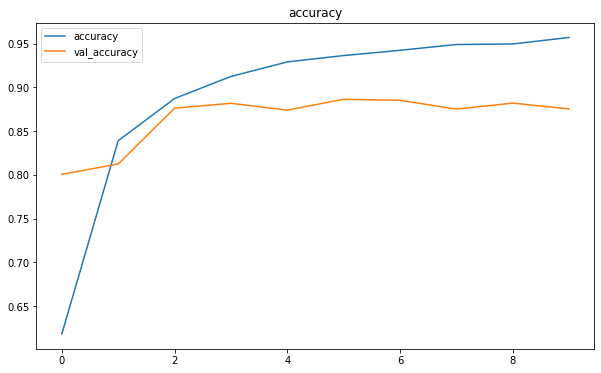

In [0]:
#  10 EPOCHS
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dropout(0.5))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history8= model_bidirectional.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_split=0.2)

plot_loss(history8)

plot_accuracy(history8)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))